In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
web_traffic_data= pd.read_excel("Data\Simulated_Web_traffic.xls")
web_traffic_data

,Day_Index,Simulated_Users,Simulated_New_Users
0,2018-01-01,7111,4159
1,2018-01-02,11451,6840
2,2018-01-03,11889,6940
3,2018-01-04,11027,6171
4,2018-01-05,9767,5348
...,...,...,...
1854,2023-01-29,13268,8389
1855,2023-01-30,17711,10424
1856,2023-01-31,17734,10567
1857,2023-02-01,18907,11195


In [3]:
# Check the range of 'Day_Index'
web_traffic_data['Day_Index'].min(), web_traffic_data['Day_Index'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2023-02-01 00:00:00'))

In [4]:
# Display summary information about the dataframe
# Display summary information about the dataframe
web_traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1859 entries, 0 to 1858
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Day_Index            1858 non-null   datetime64[ns]
 1   Simulated_Users      1859 non-null   int64         
 2   Simulated_New_Users  1859 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 43.7 KB


In [5]:
missing_values = web_traffic_data.isnull().sum()
data_types = web_traffic_data.dtypes

missing_values, data_types

(Day_Index              1
 Simulated_Users        0
 Simulated_New_Users    0
 dtype: int64,
 Day_Index              datetime64[ns]
 Simulated_Users                 int64
 Simulated_New_Users             int64
 dtype: object)

Missing Values:

There is one missing value in the 'Day_Index' column. This indicates a missing date entry. We'll need to address this before proceeding with further analysis.
Data Types:

'Day_Index': This column is correctly formatted as datetime64[ns], which is suitable for time series analysis.
'Simulated_Users' and 'Simulated_New_Users': Both are of type int64, indicating count data, which is appropriate for these columns.

The row with the missing 'Day_Index' value shows the following information:

Simulated_Users: 23,341,472
Simulated_New_Users: 14,964,617
Given that this is time series data, we can explore two main options to handle the missing date:

Interpolate the Missing Date: If the data is consistently recorded on a daily basis, we can interpolate the missing date based on the dates before and after the missing entry. This approach assumes a regular, sequential pattern in the dates.

Remove the Row: If interpolating the date isn't feasible or if it risks introducing inaccuracies, we can opt to remove this row from the dataset.

it appears that there is an inconsistency in the dataset. The entries around the missing 'Day_Index' are as follows:

2023-01-31: 17,734 Simulated_Users, 10,567 Simulated_New_Users
2023-02-01: 18,907 Simulated_Users, 11,195 Simulated_New_Users
Missing 'Day_Index': 23,341,472 Simulated_Users, 14,964,617 Simulated_New_Users
Notably, the row with the missing date has an unusually large number of users compared to the surrounding days. This could be an anomaly or an error in the dataset. Considering this, we have a few options:

Remove the Row with the Missing Date: Given the significant discrepancy in user numbers, it may be prudent to remove this row to avoid skewing the analysis.

Further Investigation: If this large number of users is valid and corresponds to a specific event or situation, we might need to handle it differently, such as treating it as an outlier or a special case in the analysis.

In order to conduct a further investigation of the anomaly, we should consider the following steps:

Contextual Inquiry: Determine if there was a special event or circumstance on or around the date in question that could explain the surge in web traffic. This could include marketing campaigns, special offers, events related to Jambojet, or even external factors influencing travel interest.

Data Pattern Analysis: Examine the data for similar instances of sudden spikes. If similar patterns are observed on specific dates, it might suggest regular events or seasonal effects that should be factored into the analysis.

Statistical Analysis: Perform a more detailed statistical examination of the data distribution. This can help to understand whether such spikes are extreme outliers or part of a broader pattern.

Let's start by looking for similar spikes in the data to see if this is an isolated incident or part of a recurring pattern. This will involve visualizing the data, especially focusing on the 'Simulated_Users' and 'Simulated_New_Users' columns.

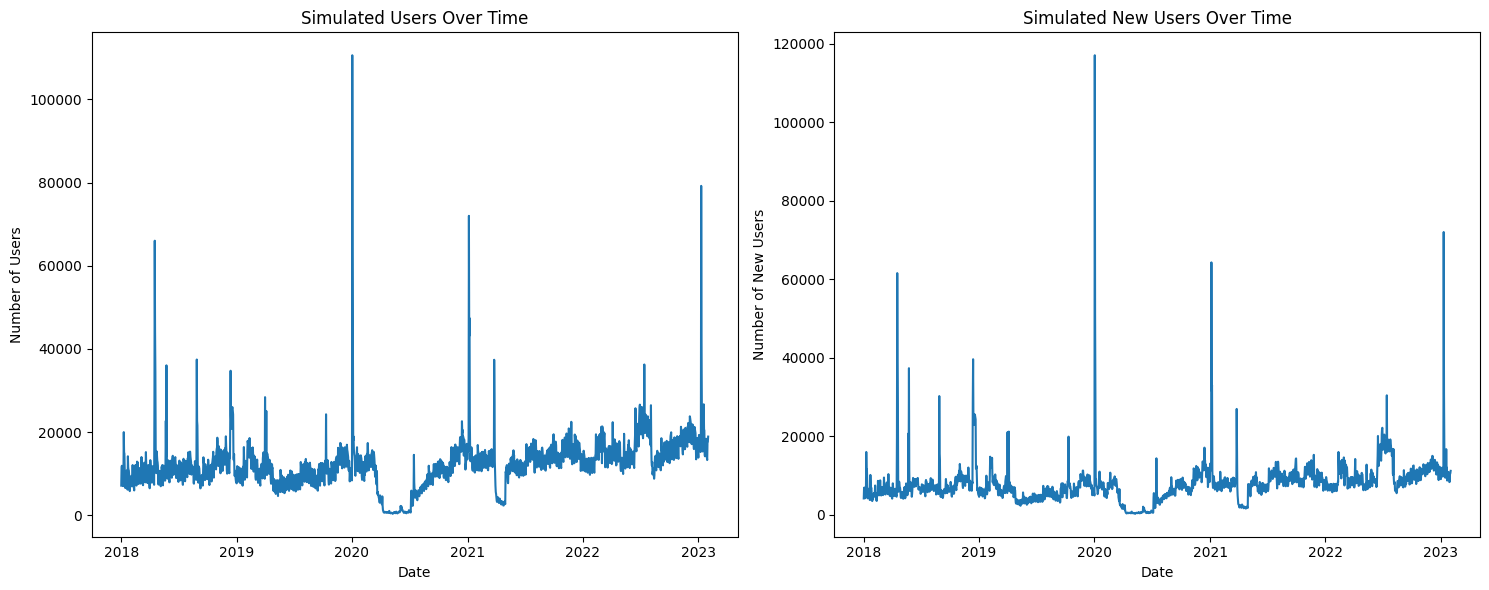

In [6]:
import matplotlib.pyplot as plt

# Visualizing the data to look for similar spikes
plt.figure(figsize=(15, 6))

# Plot for Simulated_Users
plt.subplot(1, 2, 1)
plt.plot(web_traffic_data['Day_Index'], web_traffic_data['Simulated_Users'])
plt.title('Simulated Users Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Users')

# Plot for Simulated_New_Users
plt.subplot(1, 2, 2)
plt.plot(web_traffic_data['Day_Index'], web_traffic_data['Simulated_New_Users'])
plt.title('Simulated New Users Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Users')

plt.tight_layout()
plt.show()


since the dataset appears to follow a daily sequence, we can interpolate the missing date based on the surrounding dates. We'll assume that the data is in chronological order and that the missing date follows a daily interval.

In [7]:
web_traffic_data = web_traffic_data.dropna(subset=['Day_Index'])


In [8]:
missing_values = web_traffic_data.isnull().sum()
data_types = web_traffic_data.dtypes

missing_values, data_types

(Day_Index              0
 Simulated_Users        0
 Simulated_New_Users    0
 dtype: int64,
 Day_Index              datetime64[ns]
 Simulated_Users                 int64
 Simulated_New_Users             int64
 dtype: object)

In [9]:
# Display summary statistics
web_traffic_data.describe()

,Day_Index,Simulated_Users,Simulated_New_Users
count,1858,1858.000000,1858.000000
mean,2020-07-17 12:00:00,12562.222282,8053.693757
min,2018-01-01 00:00:00,340.000000,248.000000
25%,2019-04-10 06:00:00,9511.750000,5719.250000
50%,2020-07-17 12:00:00,12344.500000,7544.500000
75%,2021-10-24 18:00:00,15208.250000,9550.750000
max,2023-02-01 00:00:00,110612.000000,117086.000000
std,NaN,6390.231945,5469.044221


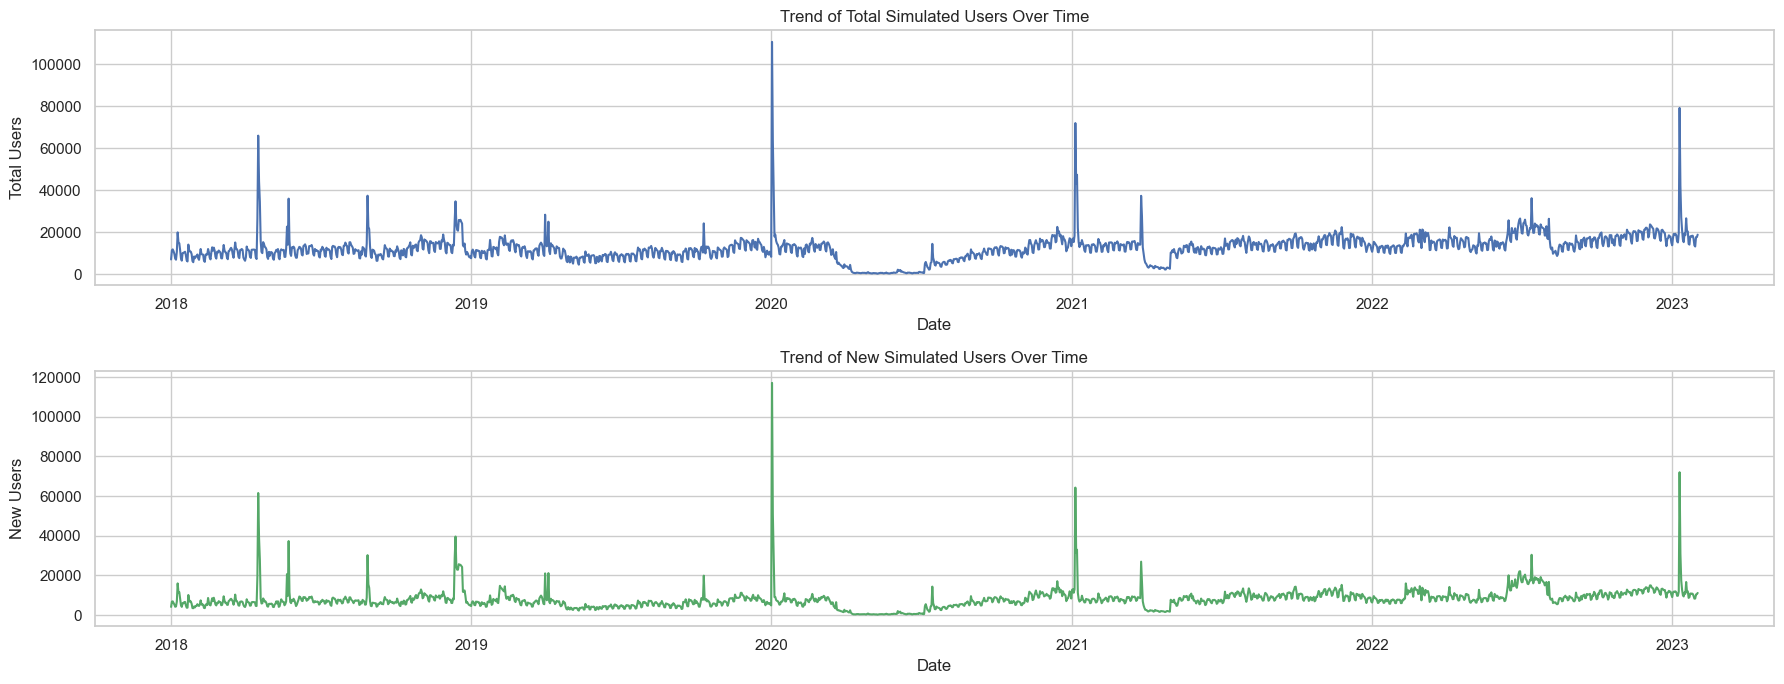

In [10]:
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Creating visualizations for Exploratory Data Analysis
plt.figure(figsize=(18, 7))

# Trend of Total Simulated Users
plt.subplot(2, 1, 1)
plt.plot(web_traffic_data['Day_Index'], web_traffic_data['Simulated_Users'], color='b')
plt.title('Trend of Total Simulated Users Over Time')
plt.xlabel('Date')
plt.ylabel('Total Users')

# Trend of New Simulated Users
plt.subplot(2, 1, 2)
plt.plot(web_traffic_data['Day_Index'], web_traffic_data['Simulated_New_Users'], color='g')
plt.title('Trend of New Simulated Users Over Time')
plt.xlabel('Date')
plt.ylabel('New Users')

plt.tight_layout()
plt.show()


the visualizations provide insights into the trends and patterns in the web traffic data for Jambojet:

Trend of Total Simulated Users Over Time:

This plot shows the overall trend in the number of total users visiting the website. We observe fluctuations over time, indicating variability in user engagement. Notable spikes might correspond to specific events or promotional activities.
Trend of New Simulated Users Over Time:

This plot focuses on the number of new users. Similar to the total users, there are noticeable fluctuations and spikes, which could be indicative of successful marketing campaigns or external factors influencing new user visits.

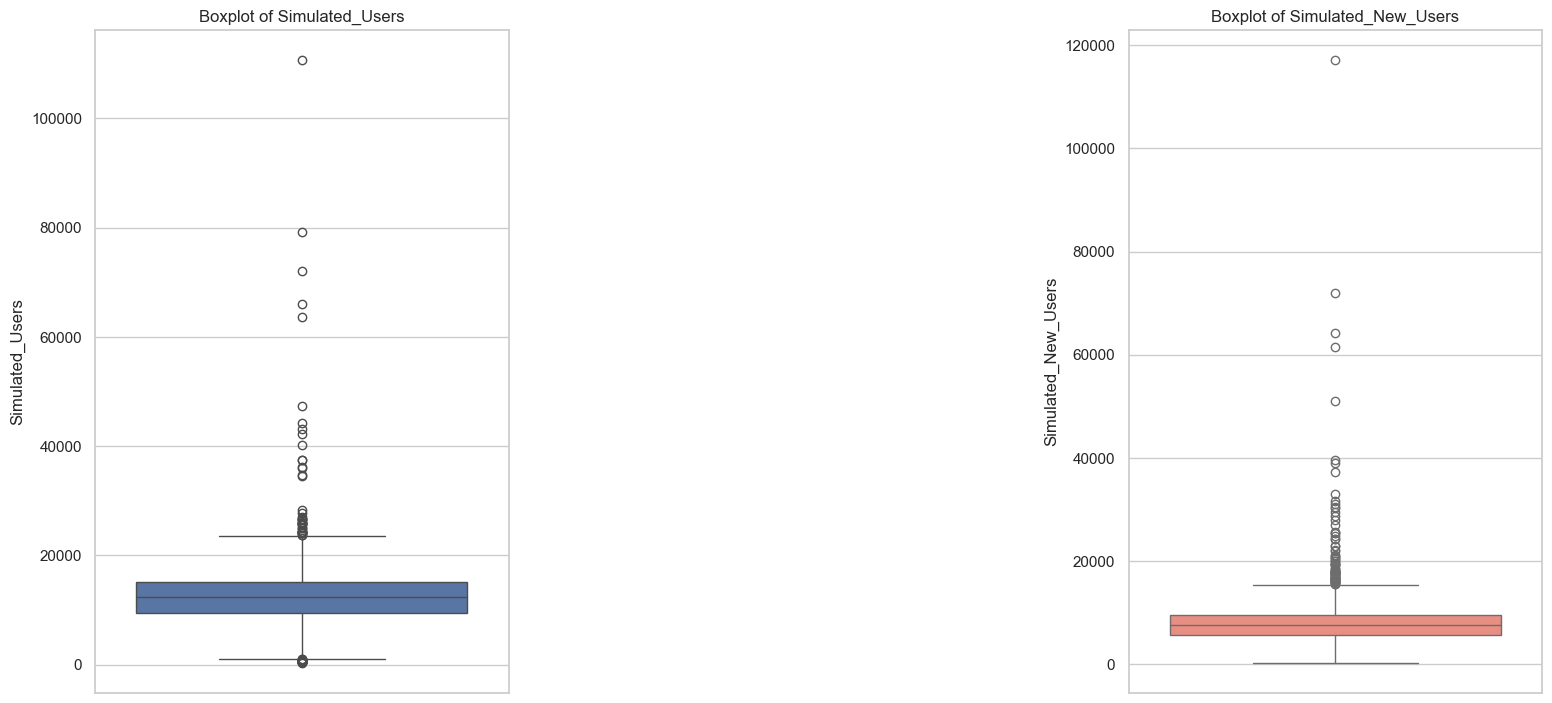

In [11]:
# Box plots for Simulated_Users and Simulated_New_Users
plt.figure(figsize=(20, 14))
plt.subplot(2, 4, 2)
sns.boxplot(y='Simulated_Users', data=web_traffic_data)
plt.title('Boxplot of Simulated_Users')

plt.subplot(2, 4, 4)
sns.boxplot(y='Simulated_New_Users', data=web_traffic_data, color='salmon')
plt.title('Boxplot of Simulated_New_Users')

plt.tight_layout()
plt.show()

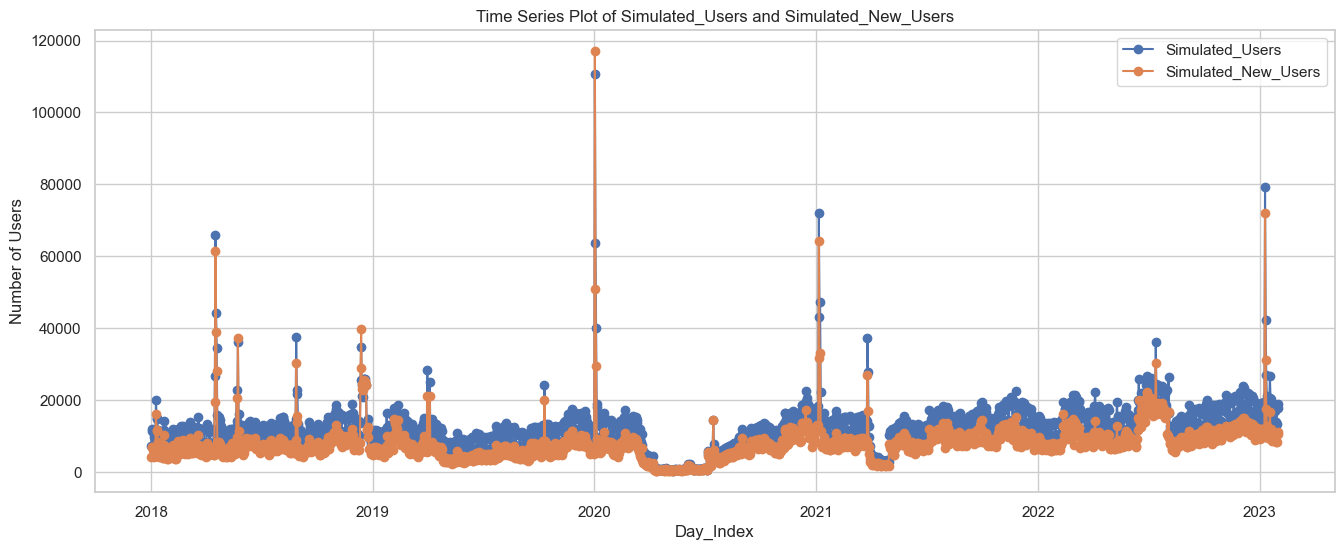

In [12]:
# Time series plot for Simulated_Users and Simulated_New_Users
plt.figure(figsize=(16, 6))
plt.plot(web_traffic_data['Day_Index'], web_traffic_data['Simulated_Users'], label='Simulated_Users', marker='o', linestyle='-')
plt.plot(web_traffic_data['Day_Index'], web_traffic_data['Simulated_New_Users'], label='Simulated_New_Users', marker='o', linestyle='-')
plt.title('Time Series Plot of Simulated_Users and Simulated_New_Users')
plt.xlabel('Day_Index')
plt.ylabel('Number of Users')
plt.legend()
plt.show()

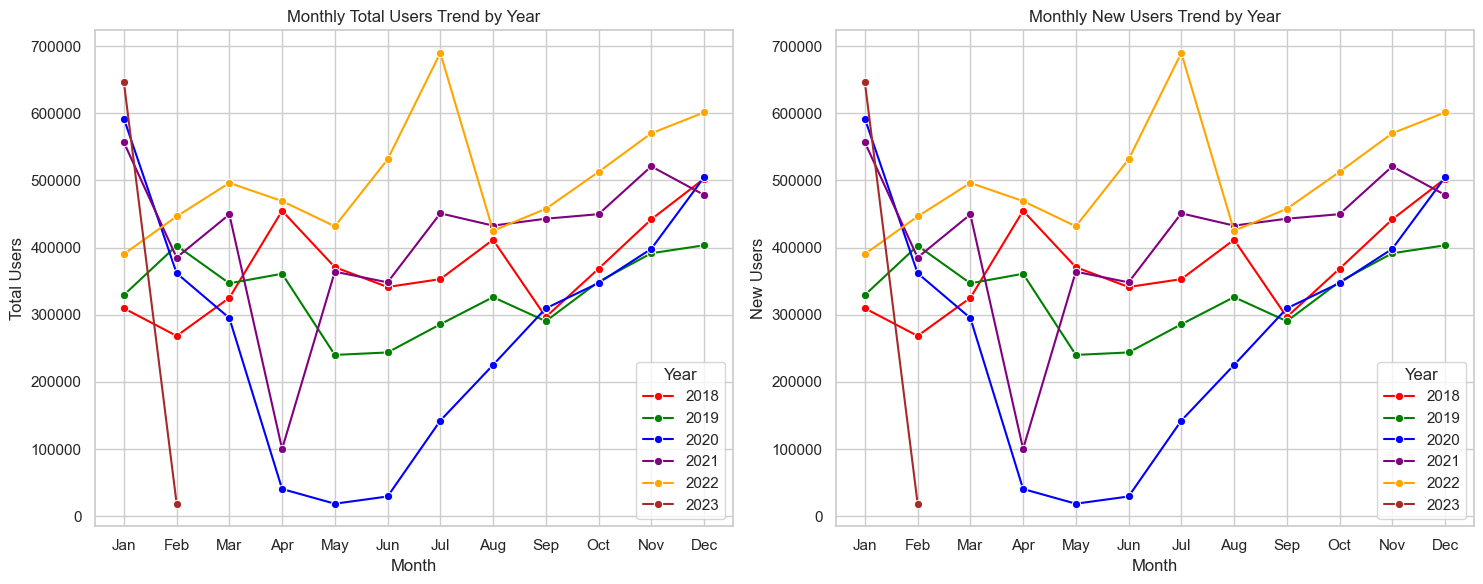

In [22]:
 # Extracting year and month for seasonal analysis
web_traffic_data['Year'] = web_traffic_data['Day_Index'].dt.year
web_traffic_data['Month'] = web_traffic_data['Day_Index'].dt.month

# Aggregating data by year and month
monthly_data = web_traffic_data.groupby(['Year', 'Month']).agg(
    Total_Users_Monthly=pd.NamedAgg(column='Simulated_Users', aggfunc='sum'),
    New_Users_Monthly=pd.NamedAgg(column='Simulated_New_Users', aggfunc='sum')
).reset_index()

# Plotting the yearly seasonal pattern
plt.figure(figsize=(15, 6))

# Total Users
plt.subplot(1, 2, 1)
custom_palette = ['red', 'green', 'blue', 'purple', 'orange', 'brown']
sns.lineplot(x='Month', y='Total_Users_Monthly', hue='Year', data=monthly_data, marker='o', palette=custom_palette)

plt.title('Monthly Total Users Trend by Year')
plt.xlabel('Month')
plt.ylabel('Total Users')
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names )  # Months from 1 to 12


# New Users
plt.subplot(1, 2, 2)
scustom_palette = ['red', 'green', 'blue', 'purple', 'orange', 'brown']
sns.lineplot(x='Month', y='Total_Users_Monthly', hue='Year', data=monthly_data, marker='o', palette=custom_palette)

plt.title('Monthly New Users Trend by Year')
plt.xlabel('Month')
plt.ylabel('New Users')

plt.xticks(range(1, 13),month_names)  # Months from 1 to 12


plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, perform an Augmented Dickey-Fuller test
    and report the results.
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # Drop na values and compute the ADF
    labels = ['ADF Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val

    print(out.to_string())  # Print the results
    print("\n")

# Assuming 'web_traffic_data' is your DataFrame and it contains 'Simulated_Users' and 'Simulated_New_Users' columns
# Performing ADF test on the 'Simulated_Users' series
adf_test(web_traffic_data['Simulated_Users'], title='Simulated Users')

# Performing ADF test on the 'Simulated_New_Users' series
adf_test(web_traffic_data['Simulated_New_Users'], title='Simulated New Users')


Augmented Dickey-Fuller Test: Simulated Users
ADF Test Statistic          -3.926642
p-value                      0.001847
# of Lags Used              22.000000
# of Observations Used    1835.000000
Critical Value (1%)         -3.433919
Critical Value (5%)         -2.863116
Critical Value (10%)        -2.567609


Augmented Dickey-Fuller Test: Simulated New Users
ADF Test Statistic       -5.962353e+00
p-value                   2.024993e-07
# of Lags Used            1.300000e+01
# of Observations Used    1.844000e+03
Critical Value (1%)      -3.433901e+00
Critical Value (5%)      -2.863109e+00
Critical Value (10%)     -2.567605e+00





**For "Simulated Users":**

ADF Test Statistic: -3.926642

p-value: 0.001847

Number of Lags Used: 22

Number of Observations Used: 1835

Critical Values:

1% Level: -3.433919

5% Level: -2.863116

10% Level: -2.567609

**Interpretation for "Simulated Users":**

ADF Test Statistic vs Critical Values: The ADF test statistic is -3.926642, which is smaller (more negative) than the critical values at 1%, 5%, and 10% levels. This suggests that the test statistic is significant.
p-value: The p-value is 0.001847, which is less than 0.05. This indicates that the null hypothesis of the ADF test (which posits that the series has a unit root and is non-stationary) can be rejected with high confidence.
Conclusion: The time series for "Simulated Users" is likely to be stationary.


For "Simulated New Users":
ADF Test Statistic: -5.962353
p-value: 2.024993e-07 (~0.0000002025)
Number of Lags Used: 13
Number of Observations Used: 1844
Critical Values:
1% Level: -3.433901
5% Level: -2.863109
10% Level: -2.567605
Interpretation for "Simulated New Users":
ADF Test Statistic vs Critical Values: The ADF test statistic is -5.962353, which is much smaller than the critical values at all levels (1%, 5%, and 10%). This suggests significant evidence against the null hypothesis.
p-value: The p-value is extremely low (close to zero), which strongly suggests rejecting the null hypothesis.
Conclusion: The time series for "Simulated New Users" is also likely to be stationary.
Overall Conclusion:
Both "Simulated Users" and "Simulated New Users" time series data are stationary based on the ADF test results

. This implies that their mean, variance, and autocorrelation structure are constant over time, which is an important property for many time series analysis techniques and forecasting models.

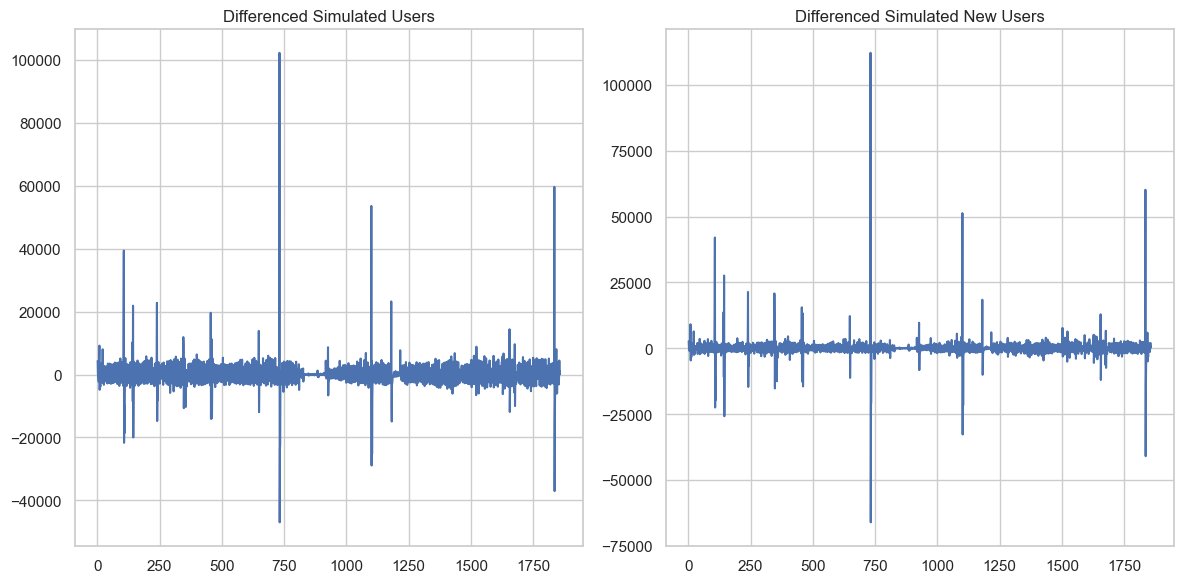

Augmented Dickey-Fuller Test: Differenced Simulated Users
ADF Test Statistic       -1.257088e+01
p-value                   2.005481e-23
# of Lags Used            2.500000e+01
# of Observations Used    1.831000e+03
Critical Value (1%)      -3.433926e+00
Critical Value (5%)      -2.863120e+00
Critical Value (10%)     -2.567611e+00


Augmented Dickey-Fuller Test: Differenced Simulated New Users
ADF Test Statistic       -1.520589e+01
p-value                   5.743499e-28
# of Lags Used            1.900000e+01
# of Observations Used    1.837000e+03
Critical Value (1%)      -3.433915e+00
Critical Value (5%)      -2.863115e+00
Critical Value (10%)     -2.567608e+00




In [24]:
# Making the series stationary
# One common method is differencing the series

# Differencing the 'Simulated_Users' series
web_traffic_data['Differenced_Simulated_Users'] = web_traffic_data['Simulated_Users'].diff().dropna()

# Differencing the 'Simulated_New_Users' series
web_traffic_data['Differenced_Simulated_New_Users'] = web_traffic_data['Simulated_New_Users'].diff().dropna()

# Plotting the differenced series to visualize changes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
web_traffic_data['Differenced_Simulated_Users'].plot(title='Differenced Simulated Users')

plt.subplot(1, 2, 2)
web_traffic_data['Differenced_Simulated_New_Users'].plot(title='Differenced Simulated New Users')

plt.tight_layout()
plt.show()

# Re-testing for stationarity with ADF test on the differenced series
adf_test(web_traffic_data['Differenced_Simulated_Users'].dropna(), title='Differenced Simulated Users')
adf_test(web_traffic_data['Differenced_Simulated_New_Users'].dropna(), title='Differenced Simulated New Users')


Differenced Simulated Users:
ADF Test Statistic: -12.57088
p-value: 2.005481e-23 (extremely low)
Number of Lags Used: 25
Number of Observations Used: 1831
Critical Values:
1% Level: -3.433926
5% Level: -2.863120
10% Level: -2.567611
Interpretation for Differenced Simulated Users:
ADF Test Statistic vs Critical Values: The test statistic is far more negative than all the critical values, indicating strong evidence against the null hypothesis.
p-value: Virtually zero, which strongly supports the rejection of the null hypothesis.
Conclusion: The differenced time series for "Simulated Users" is stationary.
Differenced Simulated New Users:
ADF Test Statistic: -15.20589
p-value: 5.743499e-28 (extremely low)
Number of Lags Used: 19
Number of Observations Used: 1837
Critical Values:
1% Level: -3.433915
5% Level: -2.863115
10% Level: -2.567608
Interpretation for Differenced Simulated New Users:
ADF Test Statistic vs Critical Values: The test statistic is significantly smaller than the critical values, indicating strong evidence against the null hypothesis.
p-value: Extremely low, further supporting the rejection of the null hypothesis.
Conclusion: The differenced time series for "Simulated New Users" is also stationary.